In [2]:
# Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import xgboost as xgb
import random
%matplotlib inline

# **Introduction** 

The main objective of this notebook is to give some insights on how to deal with data in presence of missing records. Missing data could be regarded as "records without entries". They are often denoted by a "na, n/a, N/a, N/A (not applicable)" or "Nan, NaN, NAN (not a number)". The denomination depends on the used progamming langauge (NaN is the most common in python language for machine learning). NaN values could also appear in some non authorized operation in mathematics as deviding 0 by 0 or substracting infinity from infinity (as shown in the below cell).

In [3]:
print(np.float64(0)/0)
print(np.Infinity-np.Infinity)

nan
nan


/tmp/ipykernel_4102/1487576550.py:1: RuntimeWarning: invalid value encountered in double_scalars
  print(np.float64(0)/0)


# ** Datasets**

In order to illustrate the different procedures suggested in this notebook, the [boston housing dataset](https://www.kaggle.com/altavish/boston-housing-dataset) was chosen since housing datasets are very common in Machine LEarning projects. Other datasets might be constructed on demand in some cases. 

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The following two lines are for reading the datasets from a csv file and saving them in a dataframe. The reader is supposed to be very familiar with most common librairies such as pandas, numpy, matplotlib, searborn, etc.

In [8]:
df = pd.read_csv("HousingData.csv")

Let's quickly check the size of the dataset.

In [9]:
print("The shape of the dataset is {} rows and {} columns".format(df.shape[0],df.shape[1]))

The shape of the dataset is 506 rows and 14 columns


Since only a one set of data is provided, the data will be split into two sets: train and test using sci-kit learn library.

In [10]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, train_size=0.7)

In [11]:
print("The shape of the train dataset is {} rows and {} columns (70% of the data)".format(train_df.shape[0],train_df.shape[1]))
print("The shape of the test dataset is {} rows and {} columns (30% of the data)".format(test_df.shape[0],test_df.shape[1]))

The shape of the train dataset is 354 rows and 14 columns (70% of the data)
The shape of the test dataset is 152 rows and 14 columns (30% of the data)


# Prelimenary analysis - Are there missing values?

The first step is to detect whether there is a presence of outliers or not. The following commands makes the job and get the pourcentage in an ordered way. You can either use:

In [12]:
train_df.isnull().sum().sort_values(ascending=False)/len(train_df)*100

INDUS      4.802260
CHAS       4.519774
CRIM       4.237288
AGE        3.672316
ZN         3.107345
LSTAT      2.824859
NOX        0.000000
RM         0.000000
DIS        0.000000
RAD        0.000000
TAX        0.000000
PTRATIO    0.000000
B          0.000000
MEDV       0.000000
dtype: float64

Or you can use the mean in order to get directly a pourcentage.

In [13]:
null_values_train = train_df.isnull().mean().sort_values(ascending=False)*100
null_values_train = null_values_train[null_values_train>0]

And for test set:

In [14]:
null_values_test = test_df.isnull().mean().sort_values(ascending=False)*100
null_values_test = null_values_test[null_values_test>0]

We can already get some insights about the distribution of nan values. Let us plot the pourcentage of missing values in train and test set per column.

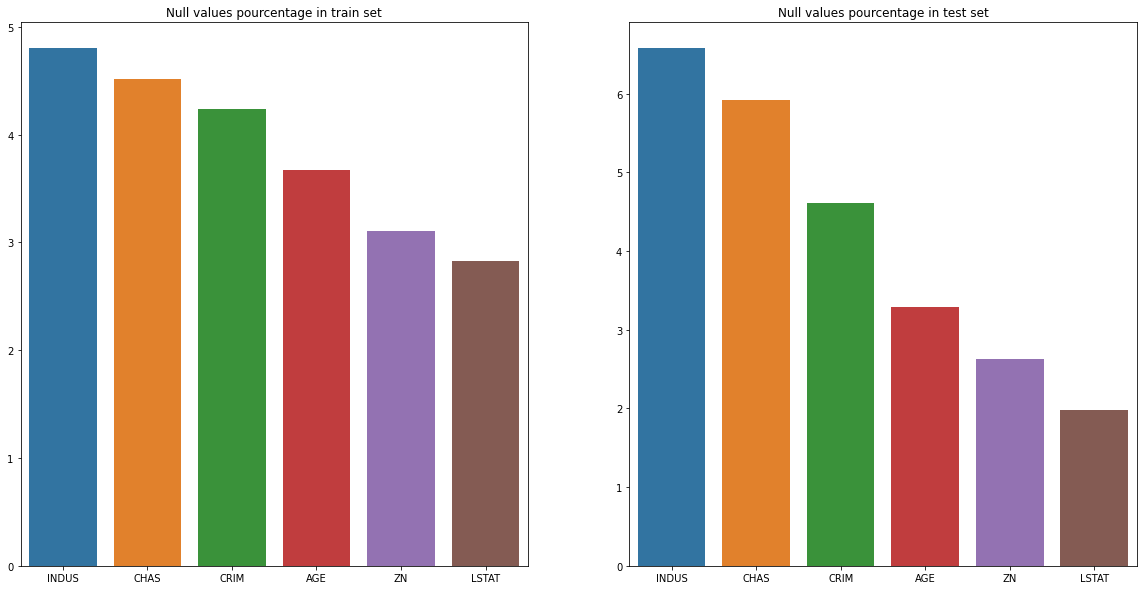

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sns.barplot(x=null_values_train.index, y=null_values_train.values, ax=ax[0]).set_title('Null values pourcentage in train set')
sns.barplot(x=null_values_train.index, y=null_values_test.values, ax=ax[1]).set_title('Null values pourcentage in test set')
plt.show()

We observe that in the case of feature "ZN", the pourcetage is the same in the training set as well as in the test set. We hold this remark for the moment and resume our analysis. 

One question that may arise: Are missing data so preblematic at this point? Couldn't we find a way to escape dealing with missing data?

# ** Do not care for missing data methods **

Suppose that we would like to predict the variable "MEDV" in the previous data set. So our dependent variable would be "MEDV" and the other will be indepednet ones. A simple manipulation is needed to adapt to the problem of Machine Learning (seperating X and y in both train and test sets).

In [16]:
X_train = train_df[[col for col in train_df.columns if col!="MEDV"]]
y_train = train_df["MEDV"]

X_test = test_df[[col for col in test_df.columns if col!="MEDV"]]
t_test = test_df["MEDV"]

Going back to my previous question whether we can perform regression or classification whitout caring too much about missing data, the answer is yes since there are some regression methods that can handle missing data because the method is built internally in a way to easily handle the missing data. The most famous method is the regression function included in the XGboost librairie. Let us check if the algorithm really can handle missing data.

In [17]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

NameError: name 'xgb' is not defined

And magic!. No errors were flagged after the fitting. The hyperparamters of the regression method must be adjusted in order to increase the performance of the algorithm. 

Let us now move to the methods that looks in detail at the distribution of the missing data.

# **Missing data strategies**

The two strategies we could follow in the case we encounter a missing value are:

* Removing the rows containing 
* Replacing the missing values

Let us apply the first solution and explore how many rows are remaining (The train set has 354). After dropping rows containig nan values in any of the columns we end with 269 rows. This means that 25% of data were dropped which will for sure include a bias in the final result.

In [18]:
train_df_dropped_na = train_df.dropna()
print("The number of rows in the train_df_dropped_na is {}".format(train_df_dropped_na.shape[0]))

The number of rows in the train_df_dropped_na is 278


The second method aims at replacing the missing data with some information infered from the whole data set such us the mean, the median, the mode, or simply a predefined value.

<font color='red'>HERE I WOULD LIKE TO FLAG A COMMON ERROR WITH THIS METHOD. THE IMPUTATION SHOULD BE THE SAME FOR BOTH TRAIN AND TEST SETS. IN OTHER WORDS, IF WE DECIDE TO REPLACE NAN VALUES WITH THE MEAN CALCULATED USING TRAIN DATA, THE SAME MEAN VALUE SHOULD BE USED FOR IMPUTATION IN TEST SET. THIS IS BECAUSE WE ARE NOT SUPPOSED TO KNOW ANYTHING ABOUT THE TEST SET.</font>

# ** Types of missing data **

A previous classification of missing data was established by [Little & Rubin in 1987](https://onlinelibrary.wiley.com/doi/book/10.1002/9781119013563) diving missing data into three categories: 

* MCAR : Missing completely at random
* MAR: Missing at random
* MNAR: Missing not at random

In order to understand the difference between the differnet types of missig data, we will try to construct them ourserlves.


## MCAR

Data missing completely at random means that the probability of missingness in one independent variable does not depend on the other observed independent variables. In other words, the probability of missingness in an indepdent variable depends only on some external factors.

For more clarification we will attempt to construct some data with a MCAR pattern. 

Let us imagine that we collect a set of 3000 entry data about some employees including: Sex, Height, Weight and Salary. We suppose that all information about sex was correctly collected (with no missing data). In a first stage, the simulated dataframe has no missing data (the missing entries will be included later).

In [19]:
N = 3000
sex = np.random.choice(["Male", "Female"], N, p=[0.6, 0.4])
height = 140 + (200-140) * np.random.rand(N)
weight = 40 + (120-40) * np.random.rand(N)
salary = 30000+(80000-30000) * np.random.rand(N)
df = pd.DataFrame(data=[sex, height, weight, salary]).transpose()
df.columns = ["Sex", "Height", "weight", "salary"]

Suppose that we want to impose that Height will have a MCAR pattern. As previously said, the missingness should be included by an external factor. We suppose that this external factor is throwing a dice, if the value is equal to 6, then the record will be missing. Let us apply this for the height variable.

In [20]:
# Initialize the Dice columns
df["Dice"] = df["Sex"]
# Fill the Dice column with the probability values
df["Dice"] = np.random.choice([1, 2, 3, 4, 5, 6], N, p=[1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
# Dtermine indices where Dice=6
index = df[df["Dice"]==6].index
# Replace with NaN
df.loc[index,"Height"] = np.nan

Now some values of the Height column were filled with NaN Values according to an MCAR scheme. The next point is to define methods to determine of the data were missing completely at random.

# **Detect the MCAR pattern**

In order to detect an MCAR pattern, we can use statistical tests. One famous statistical test for this purpose is the $\chi^2$ test. The $\chi^2$ could be used to test goodness of fit, homogenity test and independence test. The latter will be used in this case to figure out if the missigness of data in the Height column is dependent (or not) on the other variables (columns).

The test starts by stating a first hypothesis called (the null hypothesis) and calculates a measure of closness between the observed data and the expected data (in the case where the null hypothesis is satisfied).

The null hypothesis in this case is the following:

**$H_0$:** There is no association between the missingness in the Height column and the other columns. The critical $p$-value associated to this test is equal to 0.05.

Let us first define the columns "Height_missing" that equals to True if Height is missing and False otherwise.

In [21]:
# Initialize the Dice columns
df["Height_missing"] = df["Height"]
# The column is false
df["Height_missing"] = False
# Replace where Height_missing with True where Height is missing
df.loc[df[df['Height'].isnull()].index, "Height_missing"] = True

The first step is to detect if the missingness in the Height variable is relate to the Sex variable. The [Chi2 contngency test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html) from the scipy library will be used. This requires tge establishement of the contengeny table.

In [22]:
df[df["Height_missing"]==True].groupby("Sex")["Height_missing"].count()

Sex
Female    194
Male      303
Name: Height_missing, dtype: int64

In [23]:
df[df["Height_missing"]==False].groupby("Sex")["Height_missing"].count()

Sex
Female    1051
Male      1452
Name: Height_missing, dtype: int64

The contingencey table is the following:

In [ ]:
#          |   True   |   False  |

# Female   |   197    |   1025   |

# Male     |   307    |   1471   |

This table will be fed to the Chi2 contngency test from the scipy library. We expect that the degree of freedom will be 1 ((nrows-1) * (nclos-1)). This is also an information the scipy function returns.

In [ ]:
table = [[197, 1025],[307,1471]]

In [ ]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(table)

The associated $p$-value to this observation is equal to:

In [ ]:
print("The p-value is esqual to {}".format(p))

Since the $p$-value is greater that 5%, not significant result, we fail to reject null hypothesis (H0) and the two variables are indepedent.

As a conclusion, the missingness in the Height variable is not dependent on the Sex variable. Next, we should perform the same analysis for the other variables: weight and salary. This could be done in the same manner with a signle modification. Since the $chi^2$ test could not be performed between a continous and a categorical variable, the continous variables must be converted into categories by performing some binning techniques. 

**END of PART I**

**In order to keep improving this notebook, please report any mistake (logical, mathematical or even grammatical in a comment). I will do the necessary to make the necessary adjustments.**

**In the following parts, we will apply this procedure to the Boston housing dataset and look into the MAR and MNAR patterns.**